In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

In [ ]:
(train_x_orig, train_y_orig,) , (test_x_orig, test_y_orig)= fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Shape of images
print(f"Shape of training images: {train_x_orig.shape}")
print(f"Shape of training labels: {train_y_orig.shape}")
print(f"Shape of test images: {test_x_orig.shape}")
print(f"Shape of test labels: {test_y_orig.shape}")

Shape of training images: (60000, 28, 28)
Shape of training labels: (60000,)
Shape of test images: (10000, 28, 28)
Shape of test labels: (10000,)


In [ ]:
FASHION_MNIST_LABELS = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

y = 2. It's a Pullover picture.


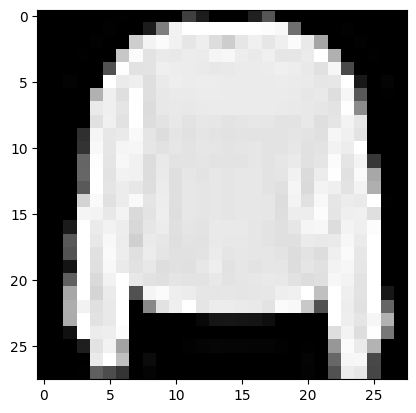

In [ ]:
index = 7
plt.imshow(train_x_orig[index], cmap='gray')
print("y = " + str(train_y_orig[index]) + ". It's a " + FASHION_MNIST_LABELS[train_y_orig[index]] + " picture.")
plt.show()

In [ ]:
# Flattening the images
train_x_flatten=train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten=test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x=train_x_flatten/255
test_x=test_x_flatten/255


print(f"Shape of flattened training images: {train_x.shape}")
print(f"Shape of flattened test images): {test_x.shape}\n")

Shape of flattened training images: (784, 60000)
Shape of flattened test images): (784, 10000)



In [ ]:
def one_hot_encoder(Y, C):
  # Y is the numpy array of labels
  # C is the number of classes
  Y_squeezed = np.squeeze(Y)
  Y_encoded = np.eye(C)[Y_squeezed.reshape(-1)].T
  return Y_encoded

# Number of classes
n_classes = 10

# Encode the original integer labels and store in the final variable 'train_y'
train_y = one_hot_encoder(train_y_orig, n_classes)
test_y = one_hot_encoder(test_y_orig, n_classes)

print(f"Shape of one-hot training labels (train_y): {train_y.shape}")
print(f"Shape of one-hot test labels (test_y):     {test_y.shape}\n")

# Check an example using the original and newly encoded labels
index = 9
print(f"Original label for example {index}: {train_y_orig[index]}")
print(f"One-hot label for example {index}:\n{train_y[:, index]}")


Shape of one-hot training labels (train_y): (10, 60000)
Shape of one-hot test labels (test_y):     (10, 10000)

Original label for example 9: 5
One-hot label for example 9:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
def initialize_parameters_he(layers_dims):
    # layers_dims is an array that contains the size of each layer
    np.random.seed(3)
    parameters={}
    L=len(layers_dims)-1

    for l in range (1, L+1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))

    return parameters

In [ ]:
# Forward pass function
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def softmax(Z):
    t = np.exp(Z - np.max(Z, axis=0))
    A = t / np.sum(t, axis=0, keepdims=True)
    cache = Z
    return A, cache

def forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

def activation(A_prev, W, b, activation_type):
    Z, linear_cache = forward(A_prev, W, b)

    if activation_type == "relu":
        A, activation_cache = relu(Z)
    elif activation_type == "softmax":
        A, activation_cache = softmax(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    # Linear -> ReLU (L-1) ---> Softmax (last layer)
    caches = []
    A = X
    L = len(parameters) // 2

    # Loop for layer 1 to L-1
    for l in range(1, L):
        A_prev = A

        A, cache = activation(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation_type="relu")
        caches.append(cache)

    # Softmax for the last layer
    AL, cache = activation(A, parameters['W' + str(L)], parameters['b' + str(L)], activation_type="softmax")
    caches.append(cache)

    return AL, caches

In [ ]:
# Cost function
def compute_cost(AL, Y):
  m = Y.shape[1]
  cost = (-1/m) * np.sum(Y * np.log(AL + 1e-8))
  cost = np.squeeze(cost)
  return cost

In [ ]:
# Back propagation
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1./m) * np.dot(dZ, A_prev.T)
    db = (1./m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)


    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dZL = AL - Y

    current_cache = caches[L-1]
    linear_cache_L, _ = current_cache
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(dZL, linear_cache_L)

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_input = grads["dA" + str(l+1)]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_input, current_cache, activation="relu")

        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp


    return grads



In [ ]:
def update_parameters(parameters, grads, learning_rate):
  L=len(parameters)//2

  for l in range(1, L+1):
    parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
    parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]


  return parameters


In [ ]:
# Main model
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_he(layers_dims)

    for i in range(0, num_iterations):
      AL, caches = L_model_forward(X, parameters)
      cost = compute_cost(AL, Y)
      grads = L_model_backward(AL, Y, caches)
      parameters = update_parameters(parameters, grads, learning_rate)

      if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)

    return parameters, costs

In [ ]:
# Prediction
def predict(X, y, parameters):
  m=X.shape[1]
  n=len(parameters)//2
  p = np.zeros((1,m), dtype=int)

  probas, caches = L_model_forward(X, parameters)
  predictions = np.argmax(probas, axis=0)

  true_labels = np.argmax(y, axis=0)

  accuracy = np.mean(predictions == true_labels)

  print(f"Accuracy: {accuracy}")

  return predictions, accuracy



Cost after iteration 0: 2.322153
Cost after iteration 100: 1.888709
Cost after iteration 200: 1.523320
Cost after iteration 300: 1.235383
Cost after iteration 400: 1.053558
Cost after iteration 500: 0.946385
Cost after iteration 600: 0.878148
Cost after iteration 700: 0.829238
Cost after iteration 800: 0.791439
Cost after iteration 900: 0.760707
Cost after iteration 1000: 0.734432
Cost after iteration 1100: 0.711415
Cost after iteration 1200: 0.691025
Cost after iteration 1300: 0.672828
Cost after iteration 1400: 0.656471
Cost after iteration 1500: 0.641745
Cost after iteration 1600: 0.628394
Cost after iteration 1700: 0.616289
Cost after iteration 1800: 0.605186
Cost after iteration 1900: 0.594942
Cost after iteration 2000: 0.585561
Cost after iteration 2100: 0.576998
Cost after iteration 2200: 0.569147
Cost after iteration 2300: 0.561898
Cost after iteration 2400: 0.555181

--- Evaluating on Training Set ---
Accuracy: 0.811

--- Evaluating on Test Set ---
Accuracy: 0.7989


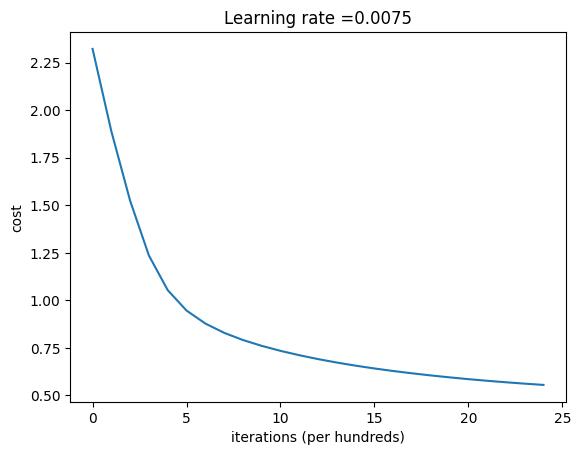

In [ ]:
layers_dims = [train_x.shape[0], 25, 12, 10]
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations=2500, print_cost=True)

print("\nEvaluating on Training Set")
pred_train, accuracy_train = predict(train_x, train_y, parameters)

print("\nEvaluating on Test Set")
pred_test, accuracy_test = predict(test_x, test_y, parameters)


plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(0.0075))
plt.show()
